# BERT - Is Solved? 

Can we use BERT to determine if a given scramble + solution sequence will result in a solved cube? 

Short answer - Kind of! 

In [118]:
import warnings
import os

warnings.filterwarnings("ignore")

import datasets
from transformers import PreTrainedTokenizerFast
from transformers import BertForSequenceClassification, BertConfig
from transformers import Trainer, TrainingArguments

from sklearn.metrics import accuracy_score, precision_recall_fscore_support

import numpy as np

from tqdm import tqdm

os.environ["WANDB_PROJECT"] = "rubiks-bert"
os.environ["WANDB_LOG_MODEL"] = "checkpoint"

BATCH_SIZE = 64
MAX_LENGTH = 140

dataset = datasets.load_from_disk("../rubiks-is-solved-dataset")
tokenizer = PreTrainedTokenizerFast.from_pretrained("../rubiks-tokenizer")

In [119]:
def process(args):
    scramble = args["scramble"]
    solve = args["solve"]
    is_solved = args["is_solved"]

    tokenized = tokenizer(
        text=scramble,
        text_pair=solve,
        is_split_into_words=True,
        return_token_type_ids=True,
        return_attention_mask=True,
        max_length=MAX_LENGTH,
        padding="max_length",
        return_tensors="pt",
    )

    tokenized["labels"] = is_solved
    return tokenized


cols_to_remove = ["scramble", "solve", "is_solved"]
processed_dataset = dataset.map(process, batched=True, remove_columns=cols_to_remove)

train = processed_dataset["train"]
test = processed_dataset["test"]

In [ ]:
config = BertConfig(
    vocab_size=tokenizer.vocab_size,
    hidden_size=512,
    num_hidden_layers=8,
    num_attention_heads=8,
    intermediate_size=1024,
    hidden_act="gelu",
    hidden_dropout_prob=0.1,
    attention_probs_dropout_prob=0.1,
    max_position_embeddings=MAX_LENGTH,
    type_vocab_size=2,
    initializer_range=0.02,
    layer_norm_eps=1e-12,
    pad_token_id=tokenizer.pad_token_id,
    position_embedding_type="absolute",
    use_cache=True,
    classifier_dropout=None,
    num_labels=2,
    id2label={1: "solved", 0: "not-solved"},
)
model = BertForSequenceClassification(config)

In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average="weighted"
    )
    acc = accuracy_score(labels, preds)
    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }


args = TrainingArguments(
    output_dir="./rubiks-bert",
    do_train=True,
    do_eval=True,
    torch_empty_cache_steps=500,
    metric_for_best_model="eval_f1",
    save_strategy="best",
    report_to="wandb",
    auto_find_batch_size=True,
    eval_strategy="epoch",
    logging_strategy="steps",
    logging_steps=100,
    eval_on_start=True,
    num_train_epochs=3,
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train,
    eval_dataset=test,
    compute_metrics=compute_metrics,
)

trainer.train()
trainer.save_model()


wandb: Currently logged in as: lainon (henry-williams) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
0,No log,0.852314,0.171989,0.029580,0.171989,0.050478
1,0.236800,0.190607,0.927055,0.933818,0.927055,0.929290
2,0.172000,0.184806,0.936424,0.937802,0.936424,0.937014
3,0.189100,0.172022,0.935755,0.937752,0.935755,0.936568
4,0.209600,0.191351,0.936711,0.937928,0.936711,0.937240
5,0.221900,0.202281,0.940344,0.940701,0.940344,0.940513
6,0.146800,0.208022,0.939771,0.941208,0.939771,0.940373
7,0.182800,0.240166,0.934895,0.935848,0.934895,0.935322
8,0.209000,0.187327,0.936902,0.938219,0.936902,0.937468
9,0.201000,0.203424,0.938432,0.939553,0.938432,0.938920


wandb: Adding directory to artifact (rubiks-bert/checkpoint-5230)... Done. 0.2s
wandb: Adding directory to artifact (rubiks-bert/checkpoint-10460)... Done. 0.2s
wandb: Adding directory to artifact (rubiks-bert/checkpoint-20920)... Done. 0.2s
wandb: Adding directory to artifact (rubiks-bert/checkpoint-26150)... Done. 0.2s
wandb: Adding directory to artifact (rubiks-bert/checkpoint-57530)... Done. 0.2s


In [122]:
from torch.utils.data import DataLoader
import torch

device = torch.device("mps")
test_loader = DataLoader(test, batch_size=64)
model = model.to(device)

all_embeddings = []
correct = []
predicted = []
actual = []

with torch.no_grad():
    for batch in tqdm(test_loader):
        input_batch = {
            "input_ids": torch.cat(batch["input_ids"]).reshape(-1, 140).to(device),
            "attention_mask": torch.cat(batch["attention_mask"])
            .reshape(-1, 140)
            .to(device),
            "token_type_ids": torch.cat(batch["token_type_ids"])
            .reshape(-1, 140)
            .to(device),
        }
        outputs = model(**input_batch, output_hidden_states=True, return_dict=True)
        predicted.append(outputs.logits.argmax(dim=-1).cpu())
        actual.append(batch["labels"])
        cls_embeddings = outputs.hidden_states[-1].mean(dim=1)
        all_embeddings.append(cls_embeddings.cpu())

embeddings = torch.cat(all_embeddings, dim=0)
predicted, actual = torch.cat(predicted), torch.cat(actual)

100%|██████████| 164/164 [00:09<00:00, 17.41it/s]


In [123]:
embeddings.shape

torch.Size([10460, 512])

In [124]:
from sklearn.manifold import TSNE

reducer = TSNE(n_components=2, perplexity=50)
reduced_embeddings = reducer.fit_transform(embeddings)

In [125]:
tp_mask = (predicted == actual) & actual
tn_mask = (predicted == actual) & ~actual
fp_mask = (predicted != actual) & actual
fn_mask = (predicted != actual) & ~actual

tp = reduced_embeddings[tp_mask.to(torch.bool)]
tn = reduced_embeddings[tn_mask.to(torch.bool)]
fn = reduced_embeddings[fn_mask.to(torch.bool)]
fp = reduced_embeddings[fp_mask.to(torch.bool)]

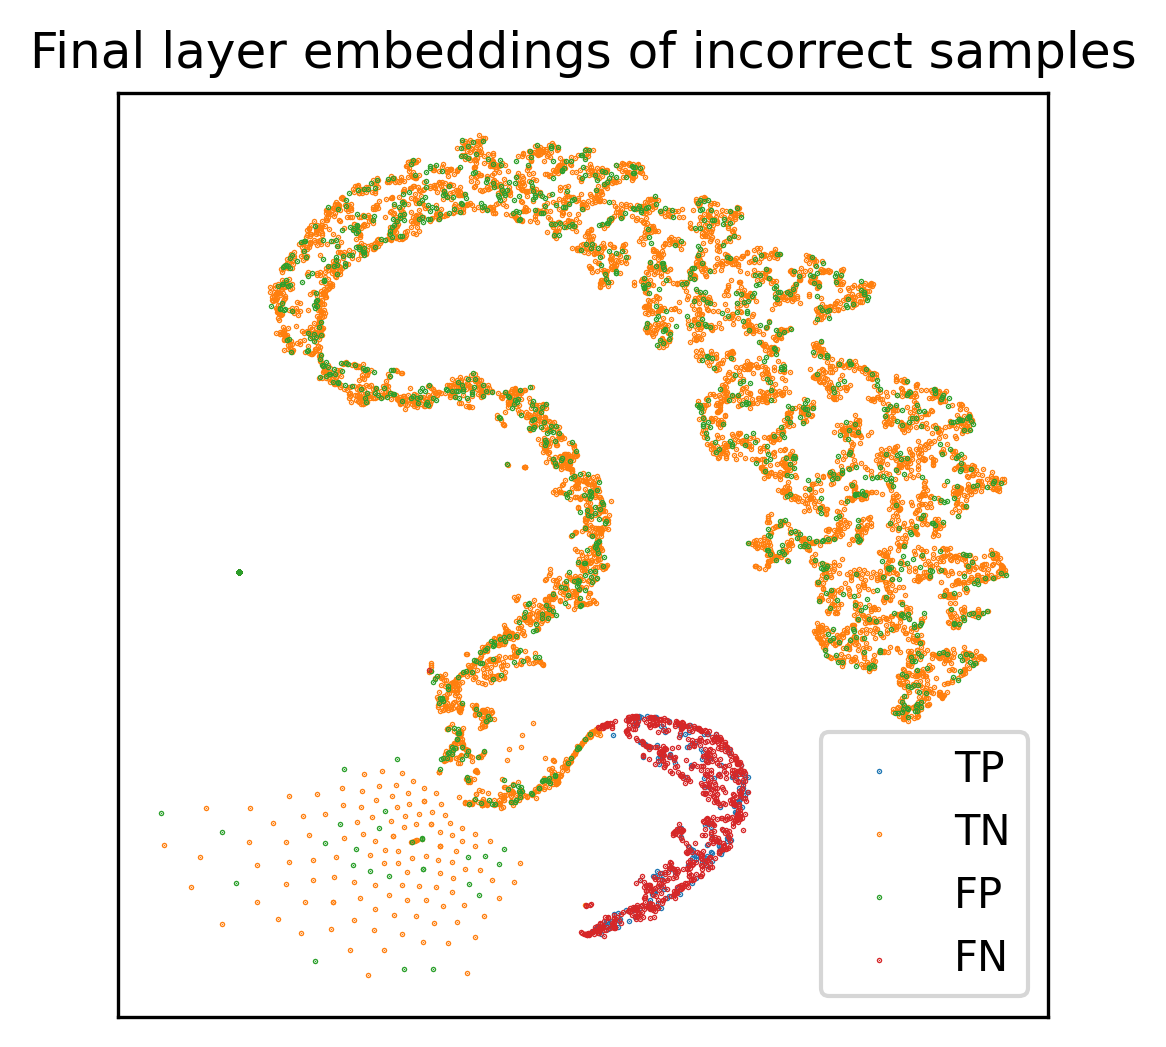

In [126]:
import matplotlib.pyplot as plt

plt.figure(dpi=300, figsize=(4, 4))
plt.title("Final layer embeddings of incorrect samples")
plt.scatter(tp[:, 0], tp[:, 1], label="TP", s=0.1)
plt.scatter(tn[:, 0], tn[:, 1], label="TN", s=0.1)
plt.scatter(fp[:, 0], fp[:, 1], label="FP", s=0.1)
plt.scatter(fn[:, 0], fn[:, 1], label="FN", s=0.1)
plt.xticks([])
plt.yticks([])
plt.legend()
plt.show()